## Airbnb Rental Price Prediction 

In this notebook, we are going to use a subset of original data from the Airbnb to predict the rental price. The data are now converted into numeric dtypes.

In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns
%matplotlib inline

In [2]:
import os
import src.data.util as util
import src.features.price as fp
import src.models.predict_price as mprice
import src.models.util as mutil

### Combining the data
To create a larger set, we combine data from Seattle and Boston. 

In [3]:
datafile_path = f'../data/processed/'
datafiles = ['boston_prices.pkl', 'seattle_prices.pkl']
datafiles = [os.path.join(datafile_path, f) for f in datafiles]

In [4]:
price_dataset = fp.combine_listings(datafiles)

**Statistics of the dataset**

In [5]:
util.stats(price_dataset, 'combined prices')

combined prices dataset has 7358 rows, 10 columns
2 columns has object type
5 columns without any missing value
0 columns missing 75% values


In [6]:
price_dataset.columns

Index(['zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'review_scores_value', 'amenities_count', 'price'],
      dtype='object')

**Columns with missing values**

In [7]:
util.cols_missing_values(price_dataset, 0)

{'bathrooms', 'bedrooms', 'beds', 'property_type', 'review_scores_value'}

In [8]:
missing = util.missing_stats(price_dataset, 'price_dataset')
print(missing)

property_type           0.054 %
bathrooms               0.408 %
bedrooms                0.217 %
beds                    0.109 %
review_scores_value    19.883 %
dtype: object


In [9]:
price_dataset.describe()

,zipcode,accommodates,bathrooms,bedrooms,beds,review_scores_value,amenities_count,price
count,7358.000000,7358.000000,7328.000000,7342.000000,7350.000000,5895.000000,7358.000000,7358.000000
mean,51845.998369,3.203452,1.241744,1.283846,1.675510,9.320102,15.090650,150.325088
std,47963.970891,1.889514,0.549948,0.823181,1.082719,0.890032,4.826422,124.227207
min,2108.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,11.000000
25%,2125.000000,2.000000,1.000000,1.000000,1.000000,9.000000,12.000000,79.000000
50%,98101.000000,2.000000,1.000000,1.000000,1.000000,9.000000,15.000000,120.000000
75%,98115.000000,4.000000,1.000000,2.000000,2.000000,10.000000,18.000000,189.750000
max,98199.000000,16.000000,8.000000,7.000000,16.000000,10.000000,31.000000,4000.000000


### Creating features 

During this phase, we'll
- Impute columns with na values.
- Encode "room_type" data with one-hot encoding. 
- For "property_type" data, encode with one-hot or a hash with a bucket size. The Hashed Feature is design pattern that addresses three possible problems associated with categorical features: incomplete vocabulary, model size due to cardinality, and cold start. It does so by grouping the categorical features and accepting the trade-off of collisions in the data representation.

**Create features and hashing property_type data**

In [10]:
price_features = fp.build_features(price_dataset, hash_property_type=True, bucket_size=5)
price_features[:2]

,zipcode,accommodates,bathrooms,bedrooms,beds,review_scores_value,amenities_count,price,room_type_Private room,room_type_Shared room,property_type
0,2131,4,1.5,2.0,3.0,9.320102,15,250.0,0,0,0
1,2131,2,1.0,1.0,1.0,9.000000,21,65.0,1,0,2


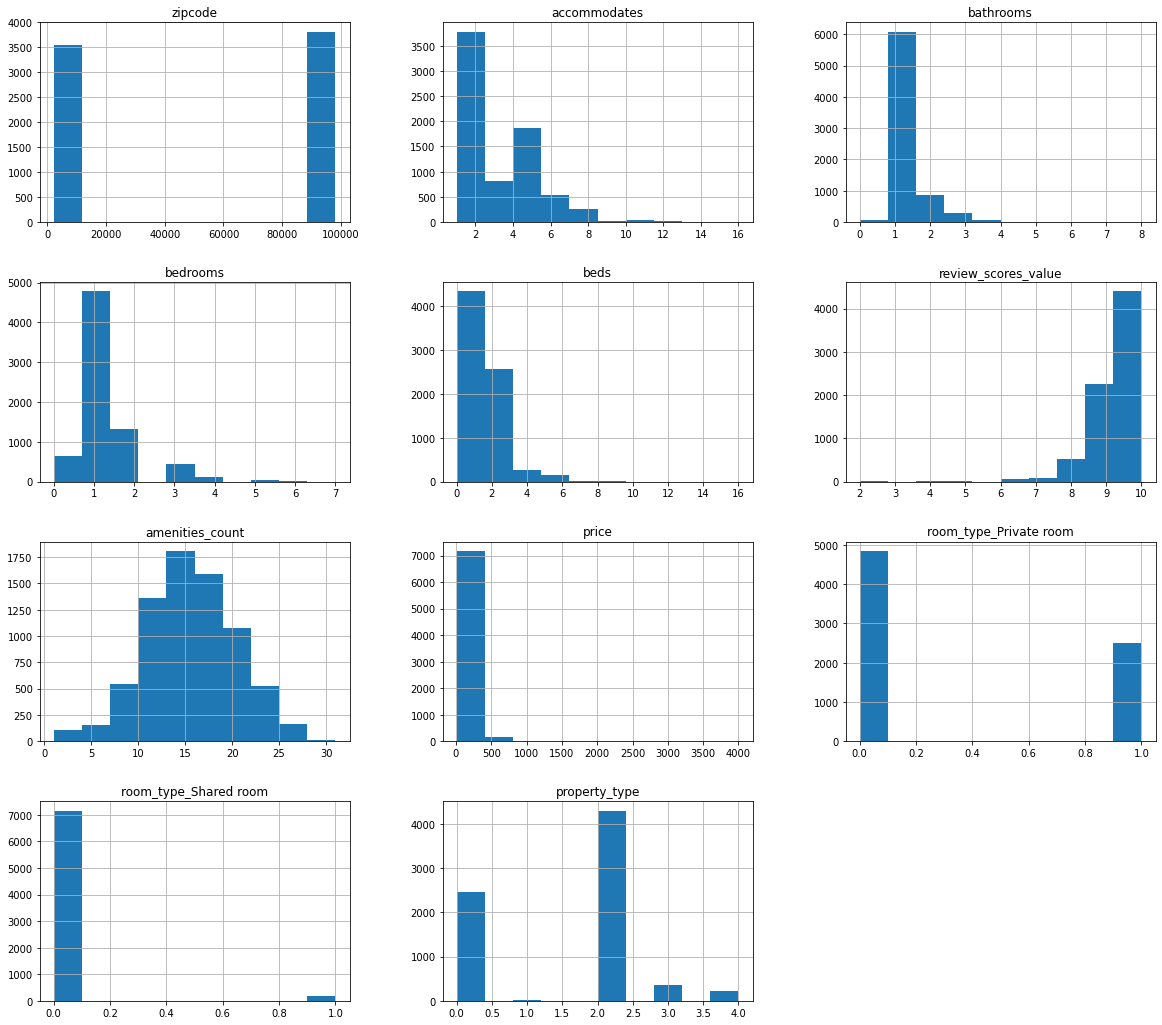

In [11]:
price_features.hist(figsize=(20, 18));

**Correlation matrix which we can see how variables are related to one another**

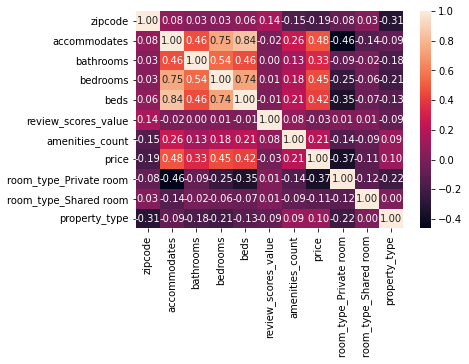

In [12]:
sns.heatmap(price_features.corr(), annot=True, fmt=".2f");

Based on chart above, variable **accomodates, bedrooms, beds, bathrooms and private room** are more related to price. **zipcode** on the other hand, doesn't seem to directly related to price.

<h3>Rental price prediction</h3>

We'll predict the price with linear model with a subset of columns from listings. Most of the data preparation follows standard procedure such as imputing missing data with mean, one hot encoding for categorical data etc. 

For property_type, encoding was done with two different options. One is to create a hash with a bucket size. The hashing is to address the general problems associated with categorical features: incomplete vocabulary, model size due to cardinality, and cold start. The other is one hot encoding.

### Predicting the price  with property_type hashed

 #### Features and fitting a model 

In [13]:
# build features using hash
price_features_hashed = fp.build_features(price_dataset, hash_property_type=True, bucket_size=5)

label_col = 'price'
X = price_features_hashed[[c for c in price_features_hashed.columns if c != label_col]]
y = price_features_hashed[label_col]

# fit a linear model
test_score, train_score, test_rmse, train_rmse, lm_model_hashed, X_train, X_test, y_train, y_test = mprice.fit_linear_mod(X, y, test_size=0.3)

**Training data and test data size**

In [14]:
print(f'train sample size: {X_train.shape}, test sample size: {X_test.shape}')

train sample size: (5150, 10), test sample size: (2208, 10)


**Model quality**

Model quality is measured with <a herf= https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html>r2_score</a> from sklean.metric. The higher the value, the better model. 


In [15]:
print(f'price prediction with hashed features: train_score: {train_score}, test_score: {test_score}')

price prediction with hashed features: train_score: 0.3666750042884528, test_score: 0.362929177598622


In [16]:
print(f'price prediction with hashed features: rmse_train: {train_rmse}, rmse_test: {test_rmse}')

price prediction with hashed features: rmse_train: 96.97820375513588, rmse_test: 103.36452421920968


**What influences Price**

In [17]:
#Use the function
coef_df = mutil.coef_weights(lm_model_hashed.coef_, X_train)

#A quick look at the top results
coef_df.head(10)

,est_int,coefs,abs_coefs
8,room_type_Shared room,-76.155599,76.155599
7,room_type_Private room,-68.569907,68.569907
3,bedrooms,34.186028,34.186028
2,bathrooms,28.524756,28.524756
1,accommodates,8.093156,8.093156
9,property_type,6.795873,6.795873
6,amenities_count,0.727495,0.727495
5,review_scores_value,0.227717,0.227717
4,beds,-0.103873,0.103873
0,zipcode,-0.000529,0.000529


The room types have largest influence to price, followed by number of bedrooms and bathrooms. 

### Predicting the price  with property_type as one hot encoding

 #### Features and fitting a model 

In [18]:
# build features without using hash
price_features_no_hash = fp.build_features(price_dataset, hash_property_type=False)
label_col = 'price'
X = price_features_no_hash[[c for c in price_features_no_hash.columns if c != label_col]]
y = price_features_no_hash[label_col]

In [19]:
# fit a linear model
test_score, train_score, test_rmse, train_rmse, lm_model_nohash, X_train, X_test, y_train, y_test = mprice.fit_linear_mod(X, y,test_size=0.3)


 #### Model quality

In [20]:
print(f'price prediction with no feature hashing: train_score: {train_score}, test_score: {test_score}')

price prediction with no feature hashing: train_score: 0.36966576353338854, test_score: 0.35907382019978795


In [21]:
print(f'price prediction with no feature hashing: rmse_train: {train_rmse}, rmse_test: {test_rmse}')

price prediction with no feature hashing: rmse_train: 96.74895203964198, rmse_test: 103.67681766904228


**What influences Price**

In [22]:
#Use the function
coef_df = mutil.coef_weights(lm_model_nohash.coef_, X_train)

#A quick look at the top results
coef_df.head(50)

,est_int,coefs,abs_coefs
25,property_type_Villa,160.049357,160.049357
16,property_type_Dorm,-97.613705,97.613705
10,property_type_Boat,84.528542,84.528542
8,room_type_Shared room,-74.476788,74.476788
7,room_type_Private room,-68.737470,68.737470
17,property_type_Entire Floor,-63.951214,63.951214
18,property_type_Guesthouse,56.681691,56.681691
24,property_type_Treehouse,37.065507,37.065507
3,bedrooms,34.050519,34.050519
2,bathrooms,28.618914,28.618914


With one hot encoding, we have a better visibility on the `property_type` and its influence to price.

**Indentify best cutoff**

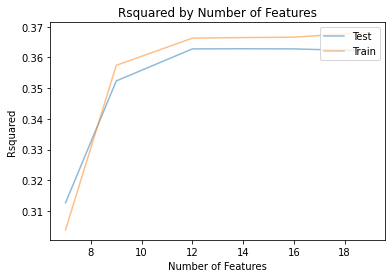

In [23]:
cutoffs = [5000, 2000, 1500, 500, 100, 50, 20, 10]
num_feats, best_cutoff, r2_scores_test, r2_scores_train, rmse_scores_test, rmse_scores_train, lm_model, X_train, X_test, y_train, y_test = mprice.find_optimal_lm_mod(X, y, cutoffs)

In [24]:
print(f'price prediction with no feature hashing: best cutoff for missing values: {best_cutoff}')

price prediction with no feature hashing: best cutoff for missing values: 50


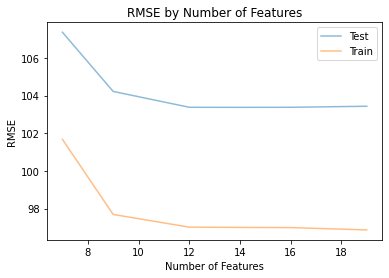

In [25]:
mprice.plot_scores(num_feats,rmse_scores_test,rmse_scores_train, ylabel='RMSE')

In [26]:
num_feats

[7, 9, 9, 9, 12, 14, 16, 19]